<center><h1>Depth Estimation Experiment - DPT-Large - Pascal VOC dataset</h1>
<h2>Matthias Bartolo</h2>

</center>

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▌       | 13/52 [00:00<00:02, 13.48it/s]


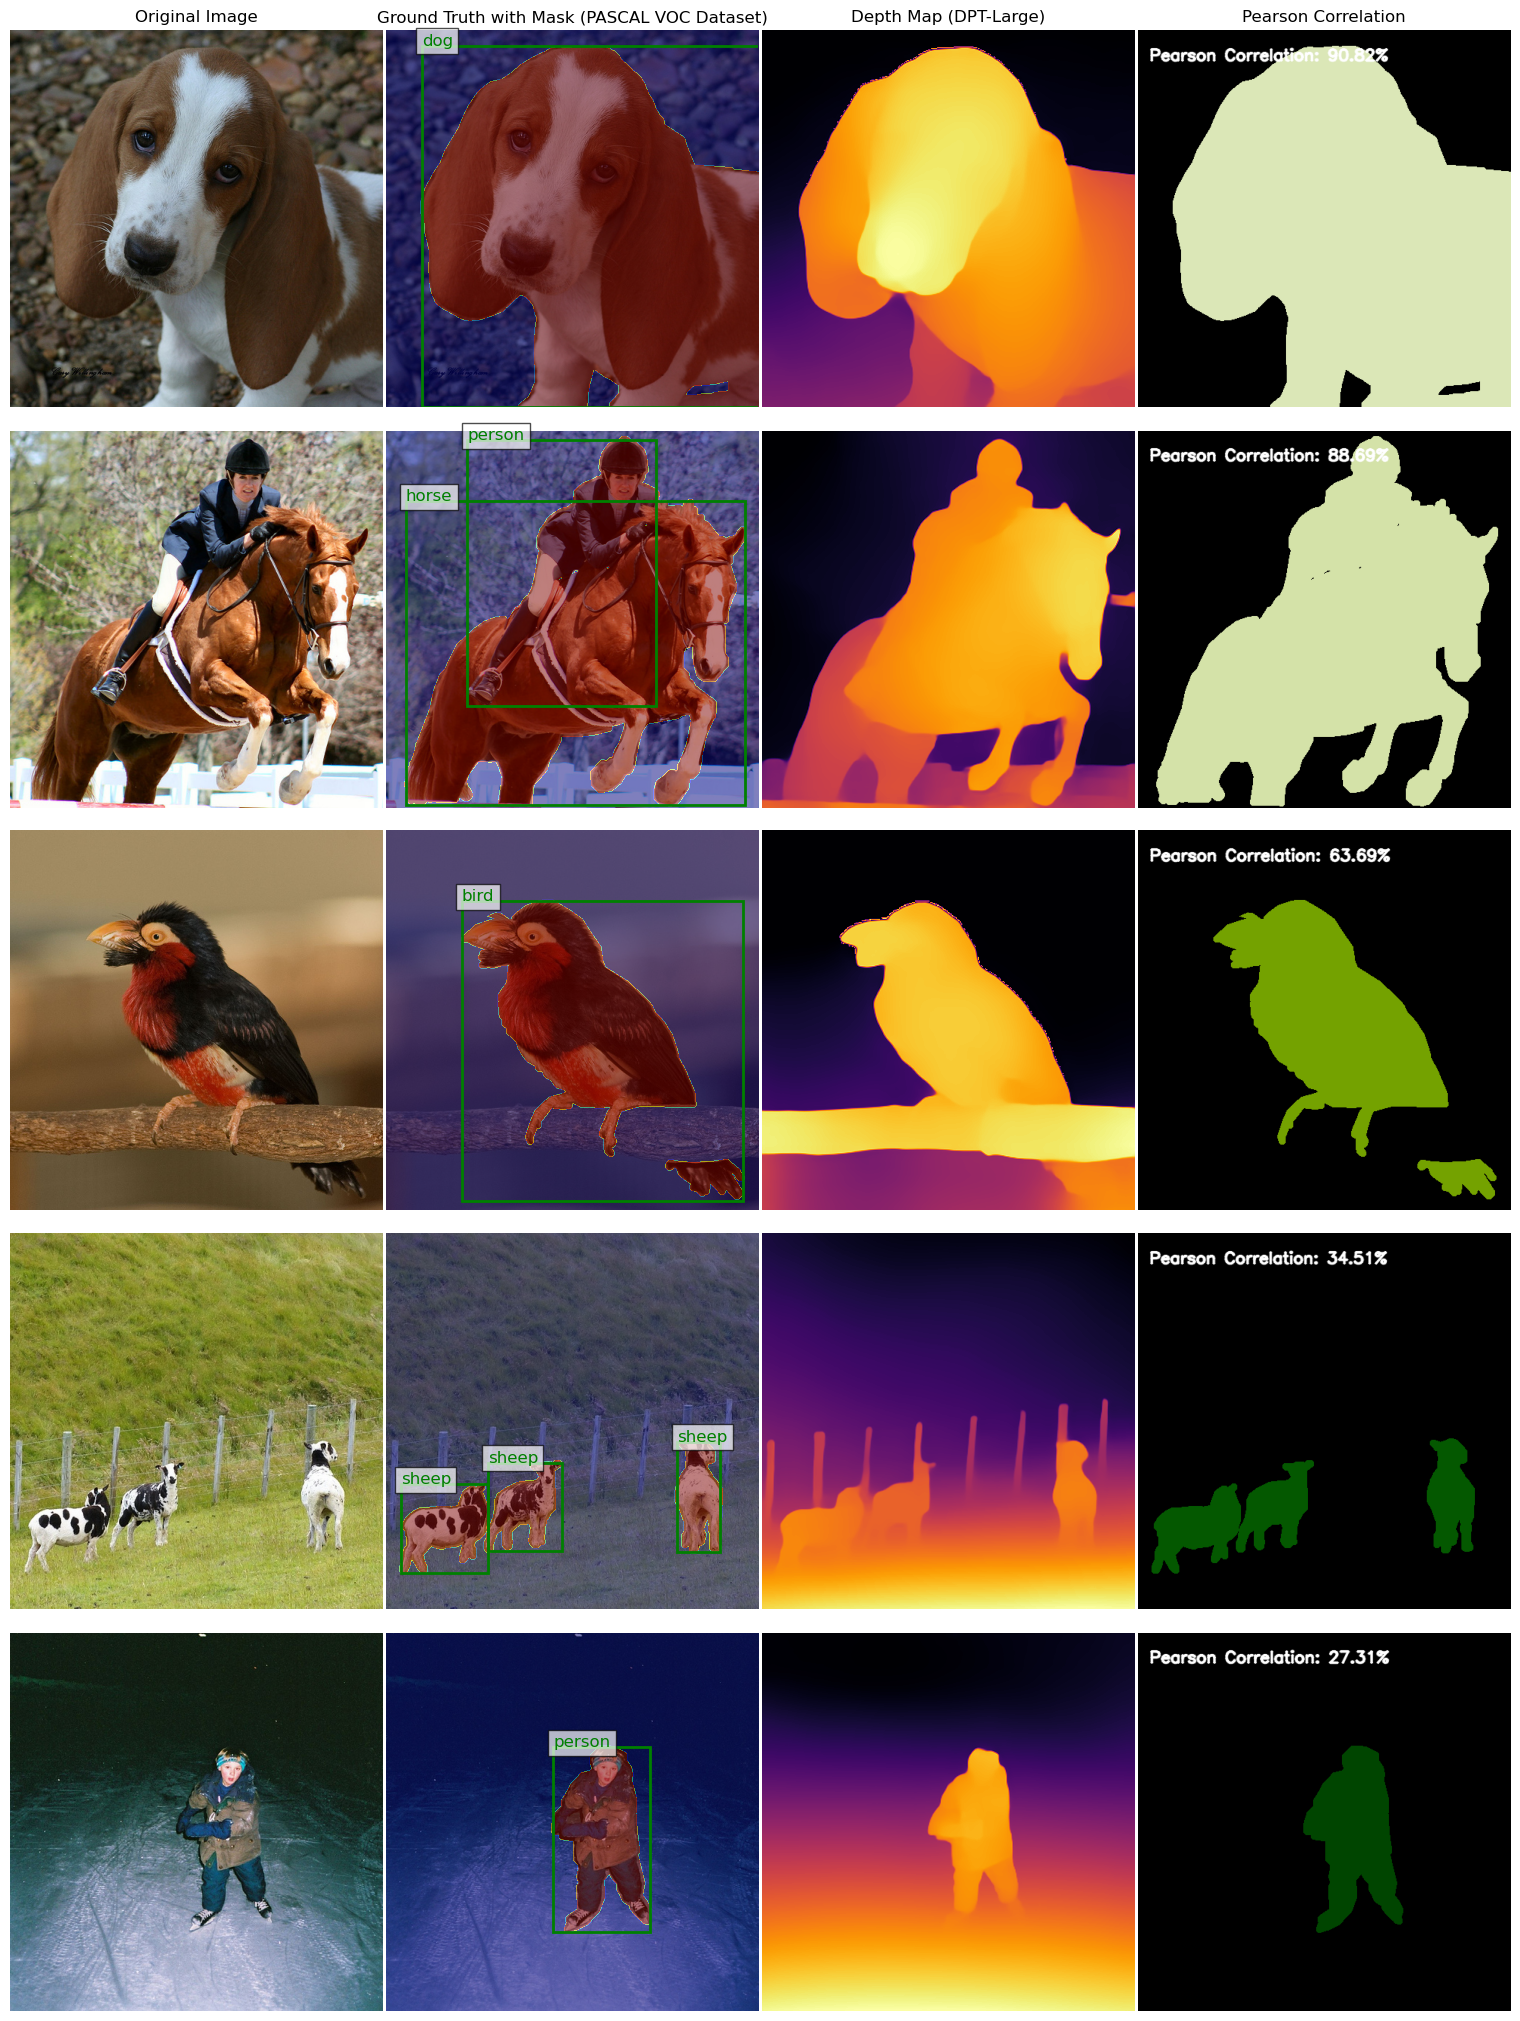

In [1]:
import os
import xml.etree.ElementTree as ET
from transformers import pipeline
from PIL import Image
import torch
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.patches as patches

# PASCAL VOC paths
voc_root = "PascalVOC2012Dataset/VOCdevkit/VOC2012"
image_folder = os.path.join(voc_root, "JPEGImages")
annotation_folder = os.path.join(voc_root, "Annotations")

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load depth estimation pipeline
pipe = pipeline(task="depth-estimation", model="Intel/dpt-large", device=device)

# Function to extract object masks, bounding boxes, and category labels from PASCAL VOC dataset
def get_voc_masks_and_category(image_id):
    # Define paths to annotations and segmentation masks
    annotation_path = os.path.join(annotation_folder, f"{image_id}.xml")
    segmentation_path = os.path.join(voc_root, "SegmentationClass", f"{image_id}.png")

    # Parse the annotation XML to get bounding boxes and categories
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bboxes = []
    categories = []

    # Iterate over all object elements in the XML
    for obj in root.findall("object"):
        category_name = obj.find("name").text
        bndbox = obj.find("bndbox")

        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        # Create a bounding box [x, y, width, height]
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        bboxes.append(bbox)
        categories.append(category_name)

    # Load the segmentation mask for the image
    if os.path.exists(segmentation_path):
        # Load the mask as a NumPy array
        object_mask = np.array(Image.open(segmentation_path))
        # If the mask is in RGB, convert it to grayscale
        if object_mask.ndim == 3:
            object_mask = cv2.cvtColor(object_mask, cv2.COLOR_RGB2GRAY)
        # Create a binary mask: any non-zero pixel is considered object
        binary_mask = (object_mask > 0).astype(np.uint8)
    else:
        binary_mask = None

    return binary_mask, bboxes, categories


# Function to process a single image and return results for grid display
def process_image(image_file):
    # Load image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    # Perform depth inference
    depth_map = pipe(image)["depth"]

    # Convert image filename to image_id (without file extension)
    image_id = os.path.splitext(image_file)[0]

    # Get the object mask, bounding boxes, and category labels for the image from PASCAL VOC annotations
    object_mask, bboxes, categories = get_voc_masks_and_category(image_id)

    if object_mask is None:
        return None

    # Resize mask to match the depth map dimensions
    depth_map_resized = cv2.resize(np.array(depth_map), (object_mask.shape[1], object_mask.shape[0]))

    # Flatten the object mask and depth map for Pearson correlation
    flattened_mask = object_mask.flatten()
    flattened_depth = depth_map_resized.flatten()

    # Pearson correlation between object mask and depth values
    correlation, _ = pearsonr(flattened_mask, flattened_depth)

    return image, object_mask, depth_map_resized, bboxes, categories, correlation

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Shuffle the image files and select 5 iamges with similar sizes
# np.random.shuffle(image_files)

# Pick the first image and then select images with similar sizes
image_file = image_files[0]
image_path = os.path.join(image_folder, image_file)
image = Image.open(image_path)
image_size = image.size

# Filter 5 images with similar sizes
target_width, target_height = image_size

image_files = [
    f for f in image_files
    if abs(Image.open(os.path.join(image_folder, f)).size[0] - target_width) <= 10 and
       abs(Image.open(os.path.join(image_folder, f)).size[1] - target_height) <= 10
]

# Only process 5 images for demonstration purposes (Sample from the images, and choose images with similar sizes)
selected_images = []
for image_file in tqdm(image_files):
    result = process_image(image_file)
    if result is not None:
        selected_images.append(result)
    if len(selected_images) == 5:
        break

# Sort images based on Pearson correlation
selected_images = sorted(selected_images, key=lambda x: x[-1], reverse=True)

# Create a 5x4 grid of images
fig, axes = plt.subplots(5, 4, figsize=(15, 25))

# Define column titles
column_titles = [
    "Original Image",
    "Ground Truth with Mask (PASCAL VOC Dataset)",
    "Depth Map (DPT-Large)",
    "Pearson Correlation"
]

# Set column titles
for col, title in enumerate(column_titles):
    axes[0, col].set_title(title, fontsize=12)

for i, (image, object_mask, depth_map, bboxes, categories, correlation) in enumerate(selected_images):
    row = i
    # Original Image
    axes[row, 0].imshow(image)
    axes[row, 0].axis("off")

    # Ground Truth with Mask and Labels
    ax = axes[row, 1]
    ax.imshow(image)
    ax.imshow(object_mask, cmap="jet", alpha=0.5)  # Overlay mask with color
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='green', facecolor='none')
        ax.add_patch(rect)
    for j, bbox in enumerate(bboxes):
        x, y, width, height = bbox
        category = categories[j]
        ax.text(x, y, category, color='green', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    ax.axis("off")

    # Depth Map
    axes[row, 2].imshow(depth_map, cmap="inferno")
    axes[row, 2].axis("off")

    # Pearson Correlation Heatmap
    correlation_map = np.zeros_like(object_mask, dtype=float)
    correlation_map[object_mask == 1] = correlation
    # Add to the correlation map white text with the correlation value
    percentage_text = f"Pearson Correlation: {correlation * 100:.2f}%"
    # Change the correlation map to RGB by turning it into a green heatmap
    correlation_map_rgb = cv2.applyColorMap((correlation_map * 255).astype(np.uint8), cv2.COLORMAP_DEEPGREEN)
    cv2.putText(correlation_map_rgb, percentage_text, (15, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
    axes[row, 3].imshow(correlation_map_rgb, cmap="Greens", vmin=-1, vmax=1)
    axes[row, 3].axis("off")

# Adjust layout to remove extra space and fit titles
plt.subplots_adjust(left=0, right=1, top=0.8, bottom=0, wspace=0.01, hspace=0.01)
plt.show()

In [2]:
import os
from transformers import pipeline
from PIL import Image
import torch
import numpy as np
import cv2
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from scipy.stats import pearsonr
import pandas as pd
import xml.etree.ElementTree as ET

# PASCAL VOC paths
voc_root = "PascalVOC2012Dataset/VOCdevkit/VOC2012"
image_folder = os.path.join(voc_root, "JPEGImages")
annotation_folder = os.path.join(voc_root, "Annotations")
segmentation_folder = os.path.join(voc_root, "SegmentationClass")

# Load category names from PASCAL VOC dataset
categories = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]

# Create a mapping from category names to IDs
category_id_to_name = {i: name for i, name in enumerate(categories)}
category_name_to_id = {name: i for i, name in enumerate(categories)}

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load depth estimation pipeline
pipe = pipeline(task="depth-estimation", model="Intel/dpt-large", device=device)

# Function to extract object masks and categories from PASCAL VOC dataset
def get_voc_masks_and_category(image_id):
    # Define paths to annotations and segmentation masks
    annotation_path = os.path.join(annotation_folder, f"{image_id}.xml")
    segmentation_path = os.path.join(segmentation_folder, f"{image_id}.png")

    # Parse the annotation XML to get bounding boxes and categories
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    bboxes = []
    categories = []

    # Iterate over all object elements in the XML
    for obj in root.findall("object"):
        category_name = obj.find("name").text
        bndbox = obj.find("bndbox")

        xmin = int(float(bndbox.find("xmin").text))
        ymin = int(float(bndbox.find("ymin").text))
        xmax = int(float(bndbox.find("xmax").text))
        ymax = int(float(bndbox.find("ymax").text))

        # Create a bounding box [x, y, width, height]
        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
        bboxes.append(bbox)
        categories.append(category_name)

    # Load the segmentation mask for the image
    if os.path.exists(segmentation_path):
        # Load the mask as a NumPy array
        object_mask = np.array(Image.open(segmentation_path))
        # If the mask is in RGB, convert it to grayscale
        if object_mask.ndim == 3:
            object_mask = cv2.cvtColor(object_mask, cv2.COLOR_RGB2GRAY)
        # Create a binary mask: any non-zero pixel is considered object
        binary_mask = (object_mask > 0).astype(np.uint8)
    else:
        binary_mask = None

    return binary_mask, bboxes, categories

# Function to process a single image and compute Pearson correlation per category
def process_image(image_file):
    # Load image
    image_path = os.path.join(image_folder, image_file)
    image = Image.open(image_path)

    # Perform depth inference
    depth_map = pipe(image)["depth"]

    # Convert image filename to image_id (without file extension)
    image_id = os.path.splitext(image_file)[0]

    # Get the object mask and categories for the image from PASCAL VOC annotations
    binary_mask, bboxes, categories = get_voc_masks_and_category(image_id)

    if binary_mask is None:
        # Create a mask from bounding boxes if no segmentation mask is available
        binary_mask = np.zeros((image.size[1], image.size[0]), dtype=np.uint8)
        for bbox in bboxes:
            x, y, width, height = bbox
            binary_mask[y:y + height, x:x + width] = 1

    if binary_mask is None:
        return None

    # Resize the depth map to match the mask size
    depth_map_resized = cv2.resize(np.array(depth_map), (binary_mask.shape[1], binary_mask.shape[0]))

    # Compute Pearson correlation per category
    category_correlations = []
    for category_name in set(categories):
        mask = (binary_mask > 0).astype(np.uint8)  # Use binary mask for correlation
        
        # Flatten the object mask and depth map for Pearson correlation
        flattened_mask = mask.flatten()
        flattened_depth = depth_map_resized.flatten()

        # Compute Pearson correlation between object mask and depth values
        correlation, _ = pearsonr(flattened_mask, flattened_depth)
        
        # Save correlation and category info
        category_correlations.append({
            'image_file': image_file,
            'category_id': category_name_to_id[category_name],
            'category_name': category_name,
            'correlation': correlation
        })

    return category_correlations

# Get list of image files in the folder
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Use ThreadPoolExecutor to process multiple images in parallel
results = []
with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(executor.map(process_image, image_files), total=len(image_files)))

# Flatten the results and filter out None values
flattened_results = [item for sublist in results if sublist is not None for item in sublist]

# Convert to DataFrame for easier manipulation
df_results = pd.DataFrame(flattened_results)

# Group by category and calculate mean correlation for each category
category_mean_correlation = df_results.groupby('category_name')['correlation'].mean().reset_index()

# Calculate the overall mean correlation across all images and categories
overall_mean_correlation = df_results['correlation'].mean()

# Display overall and per-category mean correlations
print(f"Overall mean depth-object correlation: {overall_mean_correlation:.2f}\n")

print("Mean depth-object correlation per category:")
print(category_mean_correlation.to_string(index=False))

# Display the table of correlations for individual images and categories
table = df_results[['image_file', 'category_id', 'category_name', 'correlation']].to_string(index=False, header=["Image File", "Category ID", "Category Name", "Pearson Correlation"])
print("\nTable of Correlations per Image and Category:\n")
print(table)


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 25%|██▍       | 4214/17125 [03:10<09:41, 22.20it/s]C:\Users\User\AppData\Local\Temp\ipykernel_27276\1273748344.py:134: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, _ = pearsonr(flattened_mask, flattened_depth)
100%|██████████| 17125/17125 [13:01<00:00, 21.92it/s]


Overall mean depth-object correlation: 0.28

Mean depth-object correlation per category:
category_name  correlation
    aeroplane     0.186827
      bicycle     0.203147
         bird     0.296706
         boat     0.102782
       bottle     0.410442
          bus     0.111575
          car     0.197886
          cat     0.309220
        chair     0.342013
          cow     0.291641
  diningtable     0.492667
          dog     0.305336
        horse     0.371579
    motorbike     0.280930
       person     0.288732
  pottedplant     0.274222
        sheep     0.281639
         sofa     0.330572
        train     0.114988
    tvmonitor     0.255743

Table of Correlations per Image and Category:

     Image File Category ID Category Name Pearson Correlation
2007_000027.jpg          14        person            0.021455
2007_000032.jpg           0     aeroplane           -0.036729
2007_000032.jpg          14        person           -0.036729
2007_000033.jpg           0     aeroplane       

In [4]:
# Save the table of correlations
table_file = "correlation_table.csv"

df_results.to_csv(table_file, index=False)
print(f"\nCorrelation table saved to: {table_file}")

# Save the overall and per-category mean correlations in csv format
mean_correlation_file = "mean_correlations.csv"

mean_correlation_df = pd.DataFrame({
    'category_name': ['Overall'] + category_mean_correlation['category_name'].tolist(),
    'mean_correlation': [overall_mean_correlation] + category_mean_correlation['correlation'].tolist()
})

# Sort by mean correlation
mean_correlation_df = mean_correlation_df.sort_values(by='mean_correlation', ascending=False)

mean_correlation_df.to_csv(mean_correlation_file, index=False)
# Overall,0.28342201736964795
# Time-Taken, 789sec


Correlation table saved to: correlation_table.csv
